1. **(1pkt)** Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [100]:
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

In [101]:
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

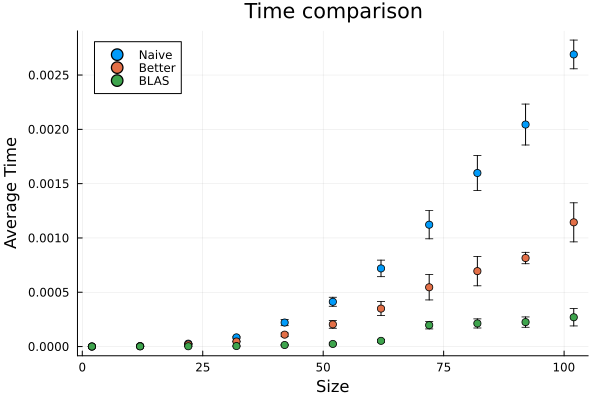

In [102]:
using DataFrames , Statistics , Plots

df = DataFrame(Size=Int[] , Naive=Float64[], Better=Float64[], BLAS=Float64[])

for i in 2:10:102
    A = rand(i,i)
    B = rand(i,i)
    for j in 1:10
        n , nt = @timed naive_multiplication(A,B)
        b ,bt = @timed better_multiplication(A,B)
        l ,lt = @timed A*B
        push!(df,(i,nt,bt,lt))
    end
end

data = combine(groupby(df, :Size), :Naive => mean, :Better => mean, :BLAS => mean, :Naive => std, :Better => std, :BLAS => std)

scatter(data.Size , xlabel = "Size" , ylabel = "Average Time", title = "Time comparison", [data.Naive_mean , data.Better_mean , data.BLAS_mean],
label = ["Naive" "Better" "BLAS"], yerr = [data.Naive_std data.Better_std data.BLAS_std])


2. **(2 pkt)** Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy (wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). 
    
    Do analizy danych można użyć wybranego narzędzia (Julia, R)
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 

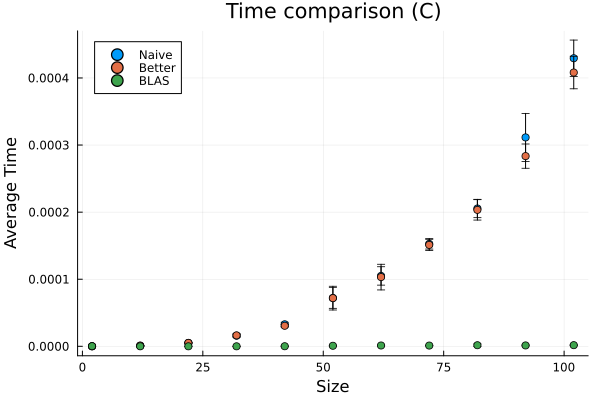

In [121]:
using CSV

df2 = CSV.read("results.csv" , delim = "," ,DataFrame)
data2 = combine(groupby(df2,:1),:2 => mean => :Naive_mean,:2=> std => :Naive_std, :3 => mean => :Better_mean, :3 => std => :Better_std, :4 => mean => :BLAS_mean, :4 => std => :BLAS_std)
scatter(data2.size , xlabel = "Size" , ylabel = "Average Time", title = "Time comparison (C)", [data2.Naive_mean , data2.Better_mean , data2.BLAS_mean],
label = ["Naive" "Better" "BLAS"], yerr = [data2.Naive_std data2.Better_std data2.BLAS_std])

3. **(1 pkt)** Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. Do analizy danych można użyć wybranego narzędzia (Julia, R)

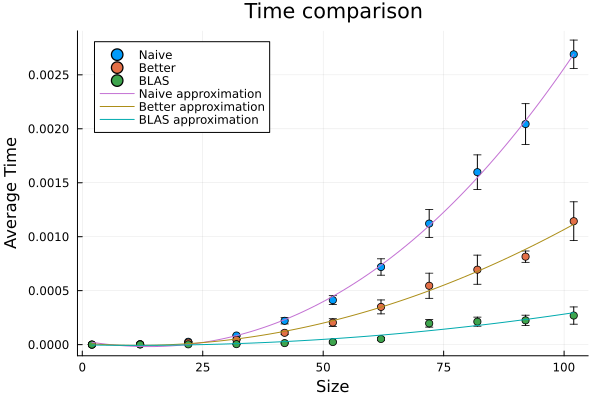

In [104]:
using Polynomials
f1 = fit(data.Size, data.Naive_mean, 3)
f2 = fit(data.Size, data.Better_mean, 3)
f3 = fit(data.Size, data.BLAS_mean, 2)

range = 2:1:102

plot!(f1,extrema(range)...,label="Naive approximation")
plot!(f2,extrema(range)...,label="Better approximation")
plot!(f3,extrema(range)...,label="BLAS approximation")

4. **(1 pkt)** Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres.

In [118]:
function fun(x)
    return 1/(1+x^2)
end

fun (generic function with 1 method)

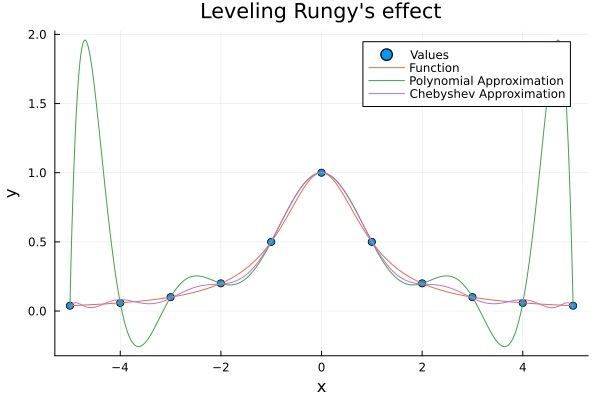

In [119]:
x = -5:1:5
y = [fun(xi) for xi in x]

f2 = fit(x,y,10)
x2 = -5:0.01:5
y2 = [f2(xi) for xi in x2]

base = [0 for i in 1:15]
push!(base,1)
ch = ChebyshevT(base)
x3 = Polynomials.roots(ch) * 5
y3 = [fun(xi) for xi in x3]
f3 = fit(x3,y3,15)
final_y = [f3(xi) for xi in x2]

scatter(x,y,xlabel = "x",ylabel = "y",label="Values", title = "Leveling Rungy's effect")

plot!(fun,extrema(x2)...,label="Function")
plot!(x2,y2,label = "Polynomial Approximation")
plot!(x2,final_y,label= "Chebyshev Approximation")



5. **(1 pkt)** Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/

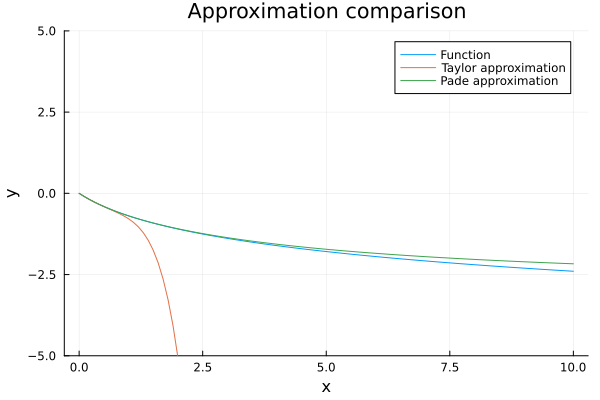

In [107]:
using TaylorSeries

function funct(x)
    -log(x+1)
end

t = Taylor1(Float64, 5)
test_taylor = test(t)
taylor = Polynomial(test_taylor.coeffs)
pade = Polynomials.PolyCompat.PadeApproximation.Pade(test_taylor_approx, 2, 2)
x = 0:0.1:10
f_y = [funct(xi) for xi in x]
t_y = [test_taylor_approx(xi) for xi in x]
p_y = [pade(xi) for xi in x]
plot(
    x,[f_y,t_y,p_y], xlabel = "x",ylabel = "y",ylims = [-5,5],title = "Approximation comparison",
    label = ["Function" "Taylor approximation" "Pade approximation"])
